# Code for fitting Astro RC data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
sns.set_palette('colorblind',10)
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
matplotlib.rc('axes',labelsize=15) 
import pandas as pd
import pystan

import os
import pickle

import omnitool
from omnitool import spyglass

import sys
%pylab inline

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


In [3]:
def read_data():
#     sfile = '../Data/MRCxyu18.csv'
    sfile = '../data/KepxDR2/MRCxyu18_wdupes_BC.csv'
    df = pd.read_csv(sfile,index_col=0)
    return df

def read_trilegal():
    tdf = pd.read_csv('../data/TRILEGAL_sim/k1.6b_K15b30_0910_new.all.out.txt',sep='\s+')
    tdf['Ak'] = omnitool.literature_values.Av_coeffs['Ks'].values[0]*tdf.Av
    tdf['MK'] = tdf.Ks - tdf['m-M0'] - tdf.Ak
    tdf['dist'] = 10.0**(tdf['m-M0'] / 5.0 + 1.0)
    tdf['parallax'] = 1./tdf.dist
    return tdf[tdf.stage==5]  

def read_data_wtgas():
    sfile = '../data/KepxDR2/MRCxyu18_wdupes_BC.csv'
    yu18 = pd.read_csv(sfile)
    sfile = '/home/oliver/PhD/Catalogues/APOKASC/APOKASC_cat_v3.6.5.txt'
    cols= ['KEPLER_ID','GAIA_PARALLAX','GAIA_PARALLAX_ERR']
    apokasc = pd.read_csv(sfile, usecols=cols, skiprows=644,sep='\s+')
    apokasc.rename(columns={'KEPLER_ID':'KICID'},inplace=True)

    #Now lets combine and make cuts
    print('X-matching Yu18xAPOKASC and Gaia Data')
    print('Before: '+str(len(yu18)))
    df = pd.merge(yu18, apokasc, on='KICID',how='outer').reindex()
    df = df[~df.numax.isnull()].reindex()

    df = df[~df.GAIA_PARALLAX.isnull()].reindex()
    df = df[df.GAIA_PARALLAX > -9000.].reindex()
    df = df[df.GAIA_PARALLAX_ERR/df.GAIA_PARALLAX < .3].reindex()

    print('After: '+str(len(df)))
    
    sg = omnitool.spyglass()
    sg.pass_parallax(df.GAIA_PARALLAX, err = df.GAIA_PARALLAX_ERR)
    sg.pass_position(df.ra, df.dec, frame='icrs')    
    sg.pass_magnitude(df.kmag, band='Ks')
    df['TGAS_MKs'], df['TGAS_MKs_err'] = sg.get_M()
    df = df[~df.TGAS_MKs.isnull()].reindex()    
    
    return df
    
def normal(x, mu, sigma):
    return (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-(x - mu)**2/(2*sigma**2))

In [4]:
df = read_data()
print('Size: '+str(len(df)))
df.head(2)

Size: 7725


,kepmag_x,Length_Quarters,Length_days,numax,numax_err,dnu,dnu_err,amplitude,err.2_x,fwhm,...,aast_MH,aast_MJ,aast_M_err,r_err,phot_MKs,phot_MKs_err,phot_MH,phot_MH_err,phot_MJ,phot_MJ_err
KICID,,,,,,,,,,,,,,,,,,,,,
892760,13.23,6,380.8,29.48,0.48,3.962,0.116,149.7,8.3,12.0,...,-1.649552,-1.190234,0.206767,160.041526,-1.475995,0.121696,-1.396375,0.121696,-0.872993,0.121696
1026084,12.14,15,1139.0,41.17,0.90,4.414,0.061,63.8,2.9,24.8,...,-1.844277,-1.358885,0.166498,164.410472,-2.058887,0.159288,-1.956892,0.159288,-1.429276,0.159288


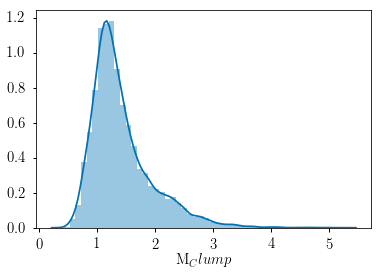

In [7]:
sns.distplot(df.M_Clump)

#### Gather the relevant data

In [4]:
sg = spyglass()
sg.pass_position(df.ra, df.dec, frame='icrs')
sg.pass_parallax(df.parallax, err=df.parallax_error)
sg.band = 'Ks'
df['Ak'] = sg.get_Aband()

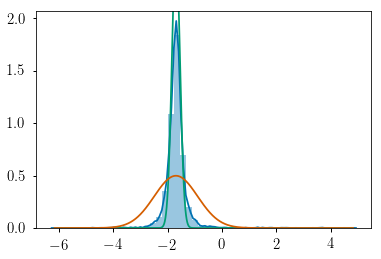

-1.6975076194980592


In [5]:
'''Step one is figuring out the different distributions we want'''
aKs = df.ast_MKs.values
pKs = df.phot_MKs.values
stage = df.stage.values
mKs = df.kmag.values
heb = stage == 2

px = np.linspace(pKs.min(),pKs.max(),1000)

pfg = normal(px, np.median(pKs), 0.15)
pbg = normal(px, np.median(pKs), .8)

sns.distplot(pKs)
plt.plot(px,pfg)
plt.plot(px,pbg)
plt.show()

print(np.median(pKs))

## Stan model for astrometric values

In [58]:
overwrite = True
asterostan = '''
functions {
    real bailerjones_lpdf(real r, real L){
        return log((1/(2*L^3)) * (r*r) * exp(-r/L));
    }
}
data {
    int<lower = 0> N;
    real m[N];
    real<lower=0> m_err[N];
    real oo[N];
    real oo_err[N];
    real<lower=0> RlEbv[N];
}
parameters {
    //Hyperparameters
    real mu;
    real muo;
    real<lower=0.> sigma;
    real<lower=0.3> sigo;
    real<lower=0.,upper=1.> Q;
    real<lower=.1, upper=4000.> L;
    
    //Latent parameters
    real M_infd_std[N];
    real Ai[N];
    real<lower = 0.> r_infd[N];
}
transformed parameters{
    //'True' parameters
    real m_true[N];
    real<lower=0.> oo_true[N];
    
    //Inferred and transformed parameters
    real M_infd[N];
    real tmuo;
    real tsigo;
    
    //Operations
    for (n in 1:N){
        M_infd[n] = mu + sigma*M_infd_std[n]; //Rescale the M fit
        oo_true[n] = 1000./r_infd[n];
        m_true[n] = M_infd[n] + 5.*log10(r_infd[n]) - 5 + Ai[n];
    }
    tmuo = muo - mu;
    tsigo = sigo / sigma;
}
model {
    //Observables
    oo ~ normal(oo_true, oo_err); //Measurement uncertainty on parallax
    m ~ normal(m_true, m_err); //Measurement uncertainty on magnitude
    
    //Hyperparameters in true space
    mu ~ normal(-1.71, .1);
    sigma ~ normal(.1, .05);
    Q ~ normal(.95, .01);
    muo ~ normal(-1.71, .01);
    sigo ~ normal(1.5, .5);

    //Latent parameters in true space
    Ai ~ normal(RlEbv, 0.05);
    for (n in 1:N){
        r_infd[n] ~ bailerjones(L);
    }
    
    //Mixture model (in transformed space)
    for (n in 1:N){
        target += log_mix(Q,
            normal_lpdf(M_infd_std[n] | 0., 1.),
            normal_lpdf(M_infd_std[n] | tmuo, tsigo));
    }
    //Unmarginalized likelihood (in true space)
    for (n in 1:N){
        target += m[n] * oo[n];
    }
}

'''

model_path = 'astrostan.pkl'
if overwrite:
    print('Updating Stan model')
    sm = pystan.StanModel(model_code = asterostan, model_name='astrostan')
    with open(model_path, 'wb') as f:
        pickle.dump(sm, f)
else:
    if os.path.isfile(model_path):
        print('Loading in existing Stan Model') 
        sm = pickle.load(open(model_path, 'rb'))
    else:
        print('Saving Stan Model') 
        sm = pystan.StanModel(model_code = asterostan, model_name='astrostan')
        with open(model_path, 'wb') as f:
            pickle.dump(sm, f)
print('Completed')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL astrostan_531ecb557df58126ccedca9900dfd2dd NOW.


Updating Stan model
Completed


#### Run the model

In [ ]:
sel = df[900:1000]
m = sel.kmag.values
m_err = np.ones(len(sel)) * 0.1 
oo = sel.parallax.values
oo_err = sel.parallax_error.values
oo_zp = -0.029
RlEbv = sel.Ak.values

dat = {'N': len(sel),
        'm': m,              #Magnitude in given band
        'm_err' : m_err,     #Magnitude error
        'oo' : oo - oo_zp ,       #Observed parallax minus the parallax zeropoint
        'oo_err' : oo_err,   #Observed parallax error
        'RlEbv':RlEbv}       #Reddening
        

initd = {'mu':-1.69,        #Red clump position
        'sigma':0.2,         #Red clump spread
        'Q': 0.95,           #Mixture model weighting factor
        'muo':-1.69,         #Centre of outlier distribution
        'sigo':1.}           #Spread of outlier distribution

fit = sm.sampling(data=dat, iter=2000, chains=1, init=[initd])

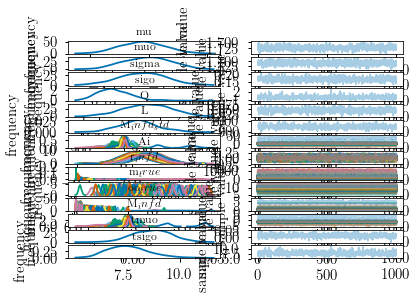

In [61]:
fit.plot()
plt.show()

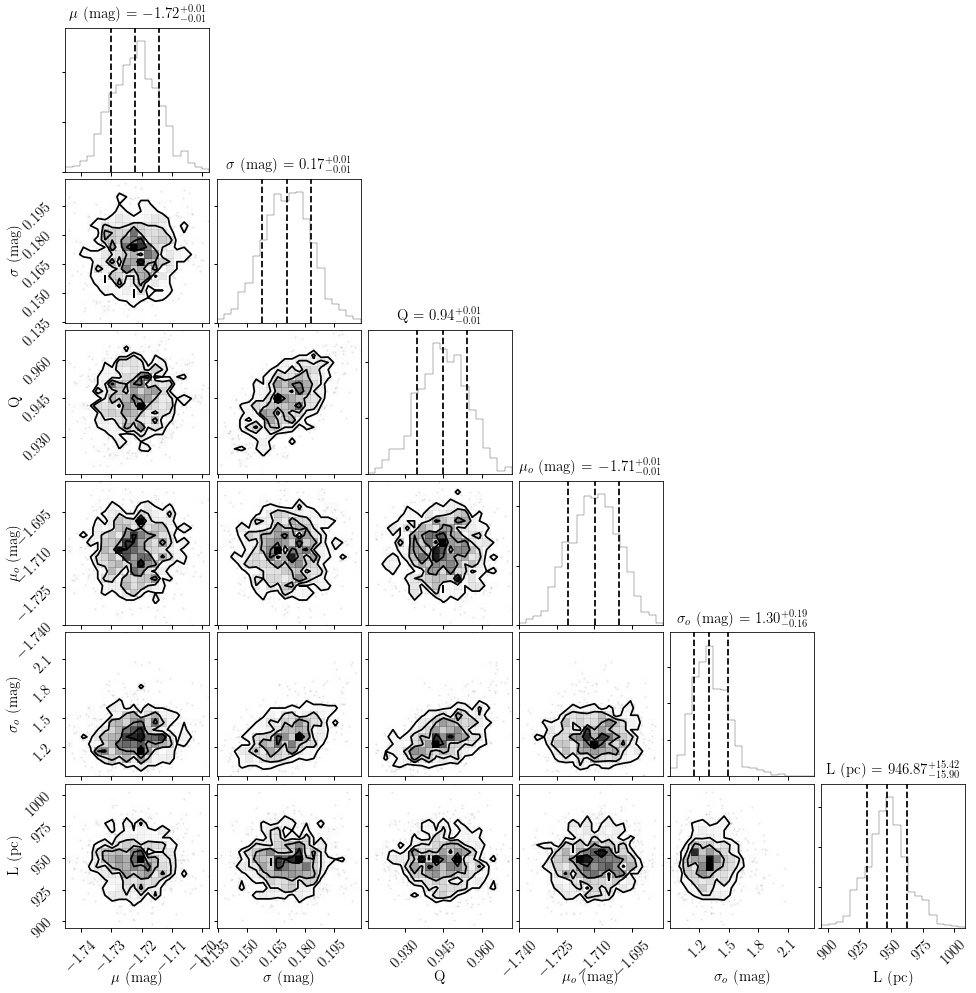

In [63]:
import corner
chain = np.array([fit['mu'],fit['sigma'],fit['Q'],fit['muo'],fit['sigo'],fit['L']])
corner.corner(chain.T,\
                labels=[r'$\mu$ (mag)',r'$\sigma$ (mag)','Q',r'$\mu_o$ (mag)',r'$\sigma_o$ (mag)','L (pc)'],\
                quantiles=[0.16, 0.5, 0.84],\
                show_titles=True, title_kwargs={"fontsize": 15})
plt.show()

In [64]:
mu = np.median(fit['mu'])
sigma = np.median(fit['sigma'])
muo = np.median(fit['muo'])
sigo = (np.median(fit['sigo']))
Q = np.median(fit['Q'])
Minfd = np.median(fit['M_infd'],axis=0)
rinfd = np.median(fit['r_infd'],axis=0)
Linfd = np.median(fit['L'],axis=0)

fg = normal(Minfd, mu, sigma)
bg = normal(Minfd, muo, sigo)
L = Q*fg + (1-Q)*bg

Text(0,0.5,u'Units arbitrary')

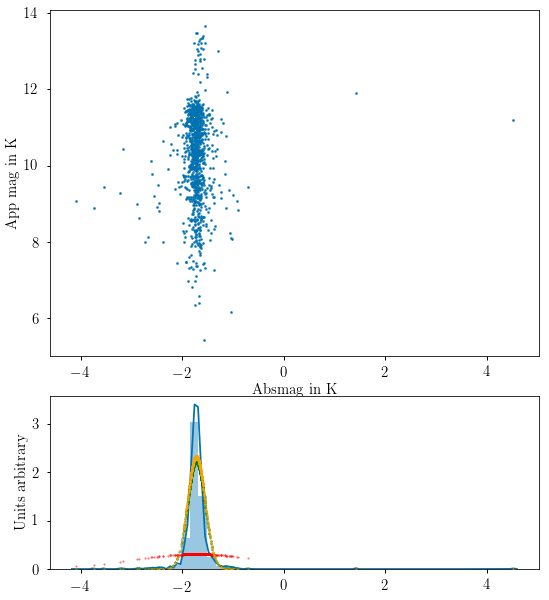

In [65]:
left, bottom, width, height = 0.1, 0.47, 0.85, 0.60
fig = plt.figure(1, figsize=(8,8))
sax = fig.add_axes([left, bottom, width, height])
xax = fig.add_axes([left, 0.1, width, 0.3],sharex=sax)

c = sax.scatter(Minfd,m,s=5,zorder=1000)

sns.distplot(Minfd,ax=xax)

xax.scatter(Minfd,fg,s=3,label='Foreground', alpha=.5,c='orange',zorder=999)
xax.scatter(Minfd,bg,s=3,label='Background', alpha=.5,c='red',zorder=998)
xax.scatter(Minfd, L,s=3,label='True likelihood', alpha=.5,c='green',zorder=997)

sax.set_xlabel('Absmag in K')
sax.set_ylabel('App mag in K')
xax.set_ylabel('Units arbitrary')

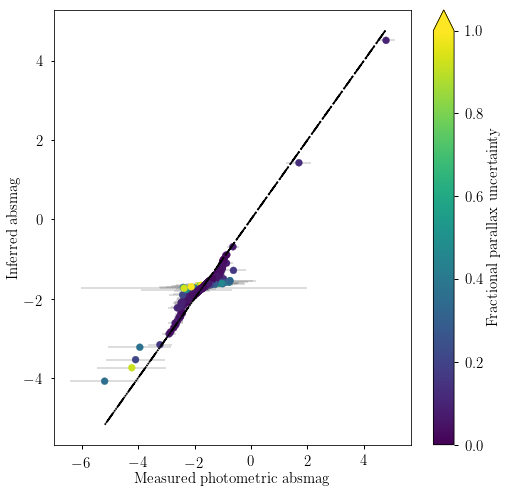

In [66]:
'''Now lets quickly compare the inferred value of M and the omnitool value'''
fig, ax = plt.subplots(figsize=(8,8))
f = np.abs(sel.parallax_error/sel.parallax)
c= ax.scatter(sel.phot_MKs, Minfd,zorder=2,c=f,vmin=0.,vmax=1.)
fig.colorbar(c, label='Fractional parallax uncertainty',extend='max')
ax.errorbar(sel.phot_MKs, Minfd,xerr=sel.phot_MKs_err,c='grey',fmt='none',alpha=.3,zorder=1)
ax.plot(sel.phot_MKs, sel.phot_MKs, c='k',linestyle='-.')
ax.set_xlabel('Measured photometric absmag')
ax.set_ylabel('Inferred absmag')
plt.show()

The above plot compares the inferred absolute Kband magnitude to the observed absolute Kband magnitude--- there are more data points at the red clump overdensity which is expected, as the points will have been placed there within the constraints of the observational uncertainties. 

There appears to be some kind of offset still, as there appears to be some correlation around the bisector at the inferred absolute magnitude positions.

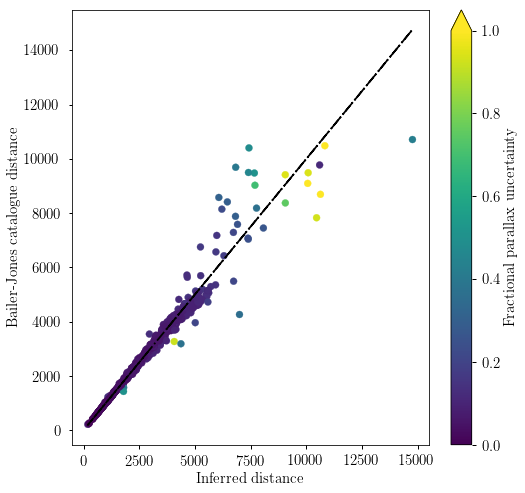

Our L: 946.8671300318973
BJ+18 median L: 1458.8604577496499


In [67]:
fig, ax = plt.subplots(figsize=(8,8))
f = np.abs(sel.parallax_error/sel.parallax)
c = plt.scatter(sel.r_est,rinfd,c=f, vmin=0., vmax=1.)
fig.colorbar(c, label='Fractional parallax uncertainty',extend='max')
ax.plot(sel.r_est, sel.r_est,c='k',linestyle='-.')
ax.set_xlabel('Inferred distance')
ax.set_ylabel('Bailer-Jones catalogue distance')
plt.show()
print('Our L: '+str(Linfd))
print('BJ+18 median L: '+str(np.median(sel.r_length_prior)))

Given that our L is smaller, we expect the mode of the prior distribution to be at a **lower distance**, and therefore we expect stars with high fractional uncertainties to be have a **lower inferred distance**. This means we would expect high fractional uncertainty stars to be *below* the bisector. That appears to be the case, although we'll need to run on more stars to confirm.

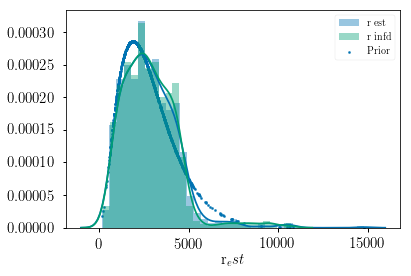

In [68]:
r = sel.r_est
prior = (1/(2*Linfd**3)) * (r*r) * np.exp(-r/Linfd)

sns.distplot(sel.r_est,label='r est')
sns.distplot(rinfd, label='r infd')
plt.scatter(r,prior,s=5,label='Prior')
plt.legend()
plt.show()

From this it looks like the best fit value of L does not comply well for the full dataset--- could this be because L varies as a function of galactic position?

Total number of Rhats: 6009
Total number of Rhats with the NaN values removed: 6009


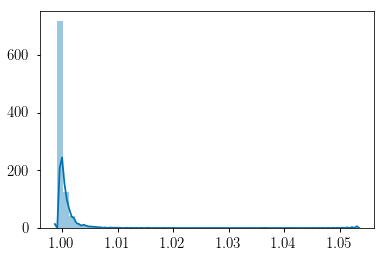

In [69]:
s = fit.summary()
rhat = s['summary'][:,-1]
rhatfin = rhat[np.isfinite(rhat)]
print('Total number of Rhats: '+str(len(rhat)))
print('Total number of Rhats with the NaN values removed: '+str(len(rhatfin)))
sns.distplot(rhatfin)
plt.show()

In [70]:
print(fit)

Inference for Stan model: astrostan_531ecb557df58126ccedca9900dfd2dd.
1 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu               -1.72  4.6e-4 8.0e-3  -1.74  -1.73  -1.72  -1.72  -1.71  303.0   1.02
muo              -1.71  3.1e-4 9.8e-3  -1.73  -1.72  -1.71   -1.7  -1.69 1000.0    1.0
sigma             0.17  1.6e-3   0.01   0.15   0.16   0.17   0.18    0.2   66.0   1.01
sigo              1.32    0.01   0.18   1.01   1.19    1.3   1.43   1.77  165.0   1.02
Q                 0.94  9.0e-4 9.7e-3   0.93   0.94   0.94   0.95   0.96  117.0   1.02
L               947.09    0.52  16.48 916.09 936.71 946.87 956.67 980.95 1000.0    1.0
M_infd_std[0]     0.85    0.02   0.66  -0.48   0.42   0.83   1.28    2.2 1000.0    1.0
M_infd_std[1]    -1.16    0.02    0.7  -2.52  -1.64  -1.14  -0.66   0.15 1000.0    1.0
M_infd_std[2]    -0.42    0.0

### Temporarily redundant code

In [ ]:
sys.exit()

In [ ]:
L = 1000.
r = np.linspace(0.1,8000, 100000)
p = (1/(2*L**3))*(r*r) * exp(-r/L)
print(p)
plt.plot(r, p)
plt.show()

In [ ]:
'''    //Hyperparameter Uniform priors for testing
        mu ~ uniform(-2., -1.);
        sigma ~ uniform(0.01, .15);
        Q ~ uniform(.8, 1.);
        muo ~ uniform(-2, -1.);
        sigo ~ normal(1.5, .5);
        L ~ uniform(0.1, 4000.);
'''

In [ ]:
plt.scatter(df.Ak_bj, df.Ak_pl)
plt.plot(df.Ak_bj,df.Ak_bj,label='Bisector',c='k',linestyle='-.')
plt.plot(df.Ak_bj,df.Ak_bj+0.05, label='+0.05mag',c='k',linestyle='-.')
plt.plot(df.Ak_bj,df.Ak_bj-0.05, label='-0.05mag',c='k',linestyle='-.')
plt.legend()
plt.xlabel('Extinction in K using Bailerjones')
plt.ylabel('Extinction in K using 1/parallax')
plt.show()